In [1]:
# load in packages
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from skimage import io
from sklearn.cluster import KMeans

# load in functions
from kinetocounter.analysis import find_centers
from kinetocounter.analysis import cluster_centers
from kinetocounter.analysis import generate_blurred_im
from kinetocounter.analysis import fit_gauss_3d

# make the plots look nice
plt.rcParams.update({'errorbar.capsize': 2})
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20) 
plt.rc('font', family='Helvetica') 
plt.rc('legend', fontsize=15) 
plt.rc('xtick', labelsize=15)   
plt.rc('ytick', labelsize=15)   

%matplotlib inline

# I. Automated analysis of candidate kinetochore centers

Input file format: `ome.tif` hyperstacks (order: xyzct) with one color channel, 1+ time points

Output: `pickle` file containing dictionary with candidate kinetochore centers (`not_tiny_list`) and other results

Method: Pixel brightness ascent

1. Threshold potential kinetochore pixel area in 3D
2. Have each pixel walk to its brightest neighbor until convergence at local maxima (pixels stop walking)
3. Filter out local maxima pixels that are dim and/or have few walkers that ended up at that pixel

In [2]:
# define list of image indices (each index is a cell)
f_idx = [3,5,10]

# iterate over all images
for idx in f_idx:
    print('Position '+str(idx))
    
    # adjust folder and filename
    folder='example_data'
    filename='cGH07_SAMPLE2_unsync_earlyAZ_stack_1_MMStack_Pos'+str(idx)+'.ome.tif'
    
    # load image and run spot finding algorithm
    im_full = io.imread(folder+'/'+filename)
    results_dict = find_centers(im_full)
    
    # save results 
    with open(folder+'/'+filename+'.pkl', 'wb') as f:
        pickle.dump(results_dict, f)
    
    # print summary of results
    for i,item in enumerate(results_dict['not_tiny_list']):
        print('time ',i,': ',len(item),' candidate centers')

Position 3
time  0 :  91  candidate centers
time  1 :  89  candidate centers
time  2 :  86  candidate centers
Position 5
time  0 :  87  candidate centers
time  1 :  89  candidate centers
time  2 :  87  candidate centers
Position 10
time  0 :  84  candidate centers
time  1 :  79  candidate centers
time  2 :  84  candidate centers


# II. Analysis results and outlier investigation

Once `pickle` files have been generated, we can check and adjust the results:
1. Visualize candidate centers overlaid on maximum intensity image of kinetochores
2. Cluster kinetochore centers to cells based on number of cells in image
3. Fit 3D Gaussians to each center and investigate outliers in integrated intensity

In [3]:
f_idx = [3,5,10]

# change the index to iterate through cells
idx = f_idx[0]

# load in image and results
folder='example_data'
filename='cGH07_SAMPLE2_unsync_earlyAZ_stack_1_MMStack_Pos'+str(idx)+'.ome.tif'
im_full = io.imread(folder+'/'+filename)
max_im_full = io.imread(folder+'/'+'MAX_'+filename)
with open(folder+'/'+filename+'.pkl', 'rb') as f:
    check_dict = pickle.load(f)
not_tiny_list = check_dict['not_tiny_list']
center_list = check_dict['center_list']
points_init_list = check_dict['points_init_list']
points_list = check_dict['points_list']
# print summary
print('Position ',idx)
for i,item in enumerate(not_tiny_list):
    print('time ',i,': ',len(item),' candidate centers')

Position  3
time  0 :  91  candidate centers
time  1 :  89  candidate centers
time  2 :  86  candidate centers


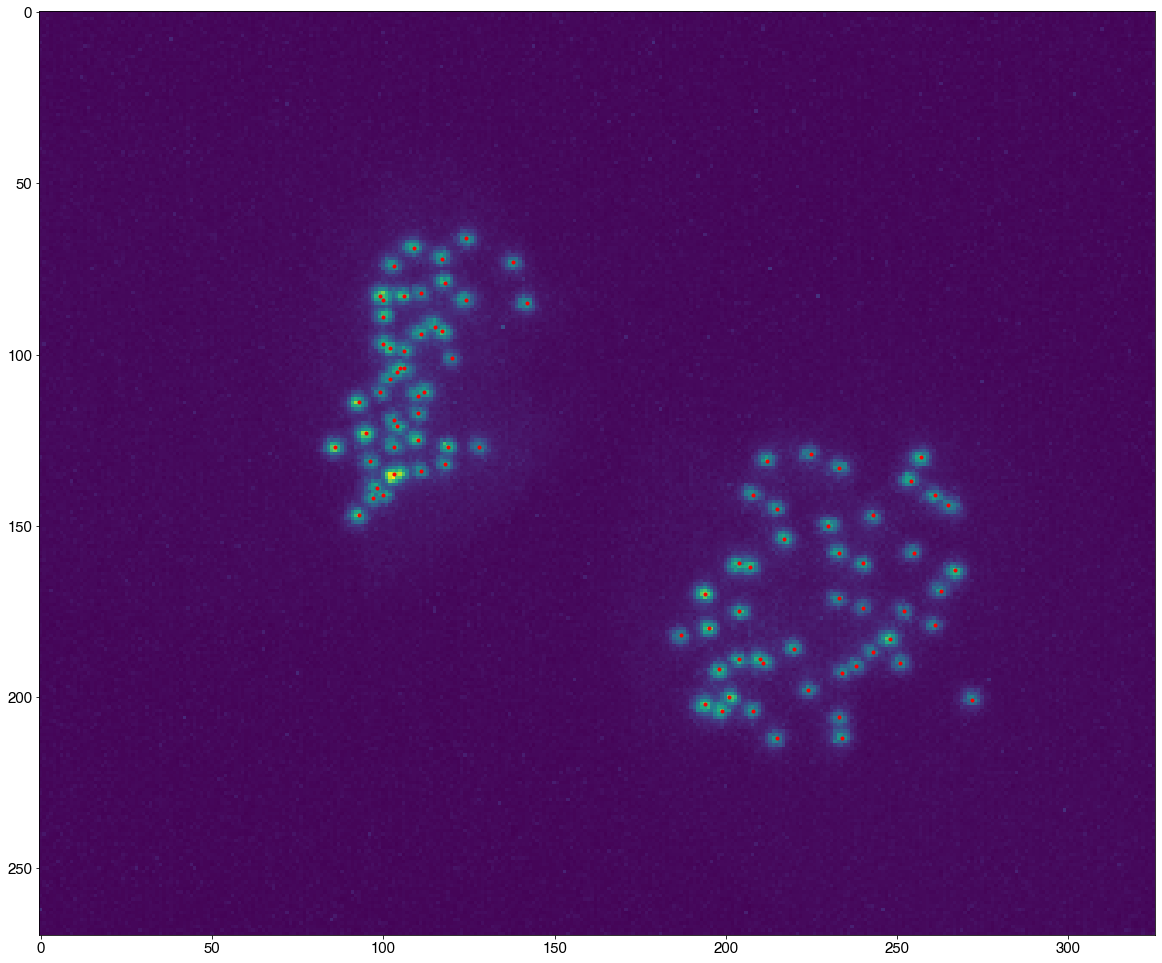

In [4]:
# choose a time point to look at
idx = 0
plt.figure(figsize=(20,20))
# plt.imshow(max_im_full[idx])
plt.imshow(max_im_full[:,:,idx])

for i in not_tiny_list[idx]:
    plt.plot(center_list[idx][i][2], center_list[idx][i][1], 'or', markersize=3)

### Clustering and visualization of counts

Perform k-means on center coordinates. Visualize counts per cell.

In [5]:
# adjust number of clusters based on image above (eg if there are 3 cells, do 3 clusters)
num_clusters =2

# perform k-means on center coordinates
kmeans_list,kt_counts = cluster_centers(center_list, not_tiny_list,num_clusters)

time index 0
kinetochore counts:  [45. 46.]
time index 1
kinetochore counts:  [45. 44.]
time index 2
kinetochore counts:  [43. 43.]


r :  45.0
b :  46.0


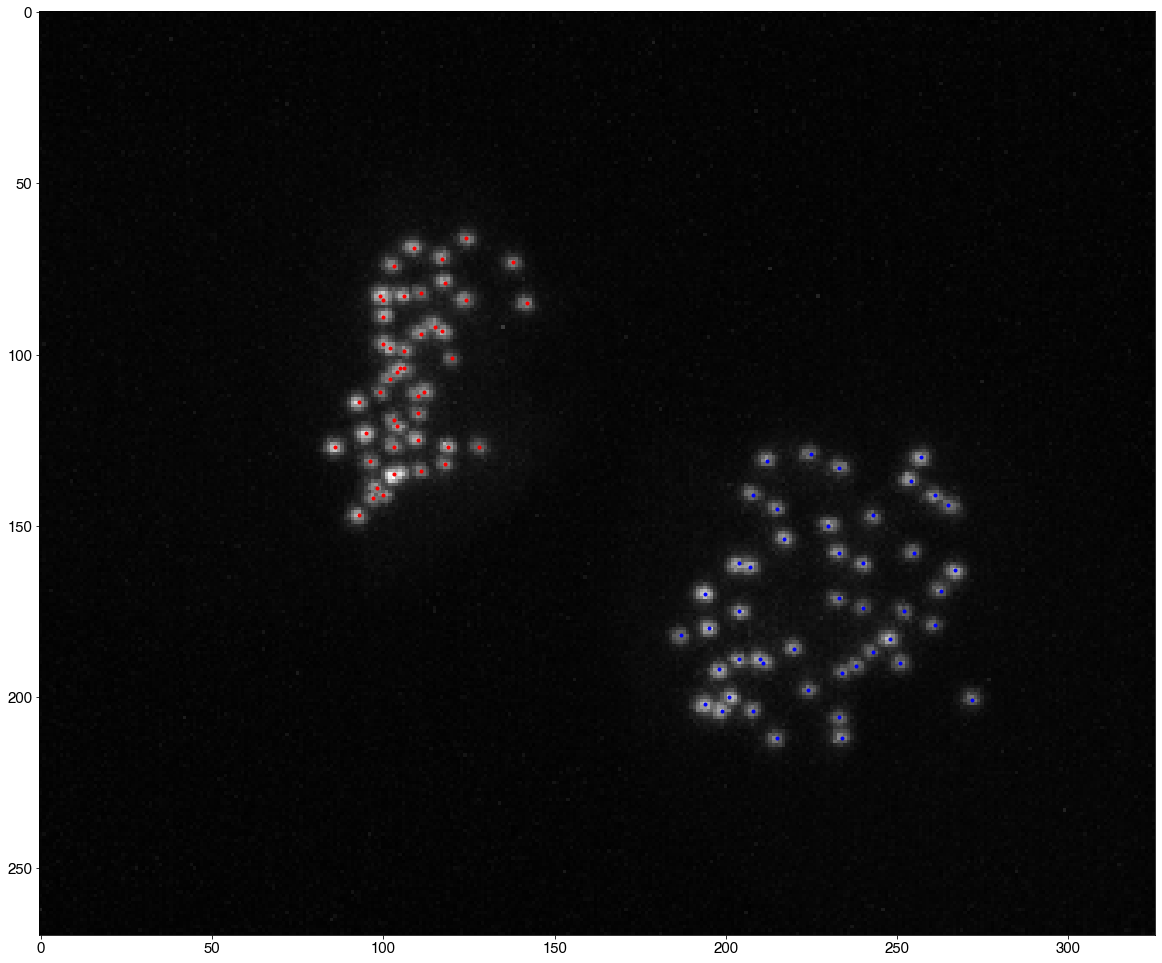

In [6]:
# choose time point to look at
idx = 0

# visualize counts
plt.figure(figsize=(20,20))
plt.imshow(max_im_full[:,:,idx], cmap='gray')
colors=['r','b','c','y','g','w','m','m']
for numb, i in enumerate(not_tiny_list[idx]):
    plt.plot(center_list[idx][i][2], center_list[idx][i][1], 'o'+colors[kmeans_list[idx].labels_[numb]], markersize=3)
for j in range(num_clusters):
    print(colors[j], ': ',kt_counts[idx][j])

### Gaussian fitting

Fit 3D Gaussians (no covariance) to each candidate center. Plot histogram of integrated intensities.

In [7]:
# add slight Gaussian blur 
blurred_im_list = [generate_blurred_im(img) for img in im_full]

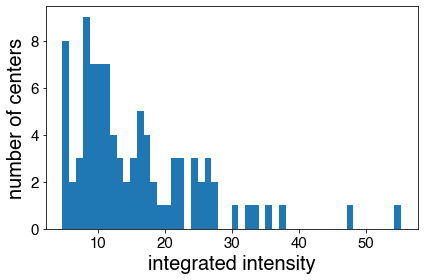

In [8]:
# choose time point to look at
idx = 0

# perform Gaussian fits on each center
gauss_df = fit_gauss_3d(idx, center_list,points_list, points_init_list,not_tiny_list,blurred_im_list)

# plot histogram of integrated intensities
nbins = int(np.max(gauss_df['int_intensity'].values)-np.min(gauss_df['int_intensity'].values))
plt.hist(gauss_df['int_intensity'].values, bins=nbins);
plt.xlabel('integrated intensity')
plt.ylabel('number of centers')
plt.tight_layout();

### Outlier investigation

Blue dots are outliers in Gaussian intensity. Compare to z-stack to check if outliers are actually clusters of 2+ kinetochores

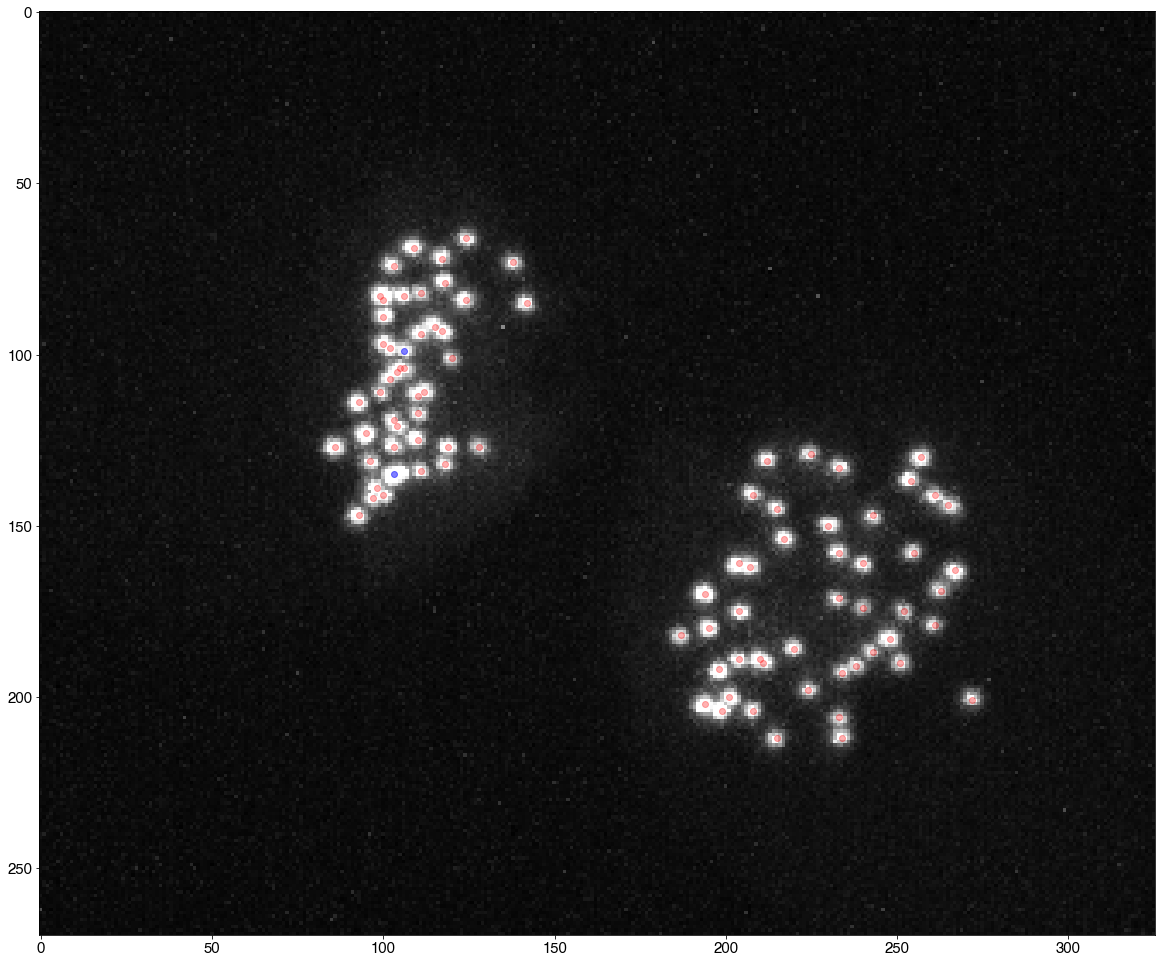

In [9]:
# adjust cutoff value based on integrated intensity histogram
cutoff_val = 40

# look at outliers
plt.figure(figsize=(20,20))
plt.imshow(max_im_full[:,:,idx],cmap='gray',vmax=300)
for ix, i in enumerate(not_tiny_list[idx]):
    if gauss_df['int_intensity'].values[ix]>cutoff_val:
        plt.plot(center_list[idx][i][2], center_list[idx][i][1], 'ob', alpha=0.5)
    else:
        plt.plot(center_list[idx][i][2], center_list[idx][i][1], 'or', alpha=0.3)